In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import time
import csv
import os
import numpy as np
import sqlite3

def fetch_ohlc_data(pool_address, bot_timestamp):
    time_diff_minutes = get_time_diff_minutes(bot_timestamp)
    interval, timeframe = get_interval_and_timeframe(time_diff_minutes)
    
    api_url = f"https://api.geckoterminal.com/api/v2/networks/solana/pools/{pool_address}/ohlcv/{timeframe}"
    headers = {"Accept": "application/json;version=20230302"}
    params = {
        "aggregate": interval,
        "currency": "usd",
        "limit": 1000,
    }

    response = requests.get(api_url, headers=headers, params=params)
    data = response.json()

    if "data" in data and "meta" in data:
        return data["data"], data["meta"]
    else:
        return None, None
    
def get_time_diff_minutes(bot_timestamp):
    current_timestamp = int(time.time())
    time_diff = current_timestamp - bot_timestamp
    time_diff_minutes = time_diff // 60
    return time_diff_minutes

def get_interval_and_timeframe(time_diff_minutes):
    if time_diff_minutes <= 1000:
        interval = 1
        timeframe = "minute"
    elif time_diff_minutes <= 5000:
        interval = 5
        timeframe = "minute"
    elif time_diff_minutes <= 15000:
        interval = 15
        timeframe = "minute"
    elif time_diff_minutes <= 60000:
        interval = 1
        timeframe = "hour"
    elif time_diff_minutes <= 240000:
        interval = 4
        timeframe = "hour"
    elif time_diff_minutes <= 720000:
        interval = 12
        timeframe = "hour"
    else:
        interval = 1
        timeframe = "day"
    
    return interval, timeframe

def plot_candlesticks(ax, df, interval):
    if interval == 1:
        width = 0.0005
    elif interval == 5:
        width = 0.002
    elif interval == 15:
        width = 0.005
    elif interval == 60:
        width = 0.02
    elif interval == 240:
        width = 0.08
    elif interval == 720:
        width = 0.24
    else:
        width = 0.5

    up = df[df["close"] >= df["open"]]
    down = df[df["close"] < df["open"]]
    
    # Plot candle body
    ax.bar(up["timestamp"], up["close"] - up["open"], width, bottom=up["open"], color="green")
    ax.bar(down["timestamp"], down["close"] - down["open"], width, bottom=down["open"], color="red")
    
    # Plot wicks
    ax.vlines(up["timestamp"], up["low"], up["high"], color="green", linewidth=0.5)
    ax.vlines(down["timestamp"], down["low"], down["high"], color="red", linewidth=0.5)

def process_data(data):
    ohlcv_data = data
    df = pd.DataFrame(ohlcv_data, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

    return df

def plot_bot_call(ax, bot_timestamp, df):
    star_size = 200
    star_color = 'magenta'
    border_color = 'black'
    border_width = 1

    # Find the closest candle timestamp to the bot call timestamp
    closest_timestamp = min(df['timestamp'], key=lambda x: abs(x - bot_timestamp))
    candle = df[df['timestamp'] == closest_timestamp]

    if not candle.empty:
        open_price = candle['open'].values[0]
        close_price = candle['close'].values[0]
        # high_price = candle['high'].values[0]
        bot_price = close_price

        ax.scatter(
            closest_timestamp,
            bot_price,
            s=star_size,
            marker='*',
            color=star_color,
            edgecolors=border_color,
            linewidths=border_width,
            label=f'Seer Call {bot_price:.5f}',
            zorder=3
        )
        
def configure_plot(ax, pool_address, meta, interval, timeframe, color=""):
    base_symbol = meta["base"]["symbol"]
    quote_symbol = meta["quote"]["symbol"]
    quote_str = quote_symbol.replace("$", "")
    interval_str = f"{interval}{timeframe[0]}"

    # Format x-axis tick labels to show hour and date
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:00"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha='right')
    
    color_emoji = ""
    if color=="green":
        color_emoji = "🟢"
    elif color=="yellow":
        color_emoji = "🟡"
    elif color=="red":
        color_emoji="🔴"
    else:
        color_emoji="❓"

    ax.set_xlabel("Time")
    ax.set_ylabel(f"Price (USD)")
    ax.set_title(f"{interval_str} price for {base_symbol}/{quote_str} pool")
    ax.legend()

    ax.grid(which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.7)
    ax.grid(which="minor", linestyle="--", linewidth=0.25, color="gray", alpha=0.4)
    ax.minorticks_on()

    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for handle, label in zip(handles, labels):
        if label == "Seer Call":
            new_handles.append(plt.Line2D([], [], marker='*', markersize=13, color='magenta', markeredgecolor='black', markeredgewidth=1, linestyle='None'))
        else:
            new_handles.append(handle)
    ax.legend(new_handles, labels)
    filename = f"{base_symbol}.png"
    return filename
    
def datetime_to_epoch(datetime_str):
    dt = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    epoch_time = int(dt.timestamp())
    return epoch_time

def get_solana_pool_address(token_address):
    api_url = f"https://api.geckoterminal.com/api/v2/networks/solana/tokens/{token_address}/pools?page=1"
    headers = {"Accept": "application/json"}

    response = requests.get(api_url, headers=headers)
    data = response.json()

    if "data" in data:
        for pool in data["data"]:
            if pool["id"].startswith("solana") and pool["attributes"]["name"].endswith("SOL"):
                return pool["attributes"]["address"]

    return None

def plot_ohlc_data(pool_address, bot_timestamp, color="unknown"):
    data, meta = fetch_ohlc_data(pool_address, bot_timestamp)
    shifted_data = data["attributes"]["ohlcv_list"]
    for t in shifted_data:
        t[0] = t[0] - 18000

    df = process_data(shifted_data)

    bot_timestamp = pd.to_datetime(bot_timestamp, unit="s")
    start_time = bot_timestamp - pd.Timedelta(minutes=10)
    filtered_df = df[df["timestamp"] >= start_time]
    if filtered_df.empty:
        filtered_df = df

    time_diff_minutes = get_time_diff_minutes(bot_timestamp.timestamp())
    interval, timeframe = get_interval_and_timeframe(time_diff_minutes)
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_candlesticks(ax, filtered_df, interval)  # Pass the interval to plot_candlesticks
    plot_bot_call(ax, bot_timestamp, filtered_df)

    # Find the candle closest to the bot call timestamp
    closest_candle = filtered_df.iloc[np.argmin(np.abs(filtered_df['timestamp'] - bot_timestamp))]
    bot_call_price = closest_candle['close'] + 0.25*(closest_candle['high'] - closest_candle["close"])
    bot_call_time = closest_candle['timestamp']

    # Find the maximum closing price after the bot call
    after_bot_call_df = filtered_df[filtered_df['timestamp'] > bot_timestamp]
    if not after_bot_call_df.empty:
        max_close_price = after_bot_call_df['close'].max()
        max_close_time = after_bot_call_df.loc[after_bot_call_df['close'].idxmax(), 'timestamp']
        max_close_timestamp = after_bot_call_df.loc[after_bot_call_df['close'].idxmax(), 'timestamp']

        # Find the minimum closing price between the bot call and the maximum closing price
        min_low_price = after_bot_call_df.loc[after_bot_call_df['timestamp'] <= max_close_timestamp, 'low'].min()
        min_low_time = after_bot_call_df.loc[after_bot_call_df['low'] == min_low_price, 'timestamp'].iloc[0]

        # Calculate the percentage gain and loss
        max_gain_pct = max((max_close_price - bot_call_price) / bot_call_price * 100, 0)
        max_loss_pct = min((min_low_price - bot_call_price) / bot_call_price * 100, 0)

        # Plot the horizontal lines for maximum gain and loss
        ax.axhline(y=max_close_price, color='green', linestyle='--', linewidth=1, label=f"Max Gain {max_close_price:.5f} ({max_gain_pct:.2f}%)")
        ax.axhline(y=min_low_price, color='red', linestyle='--', linewidth=1, label=f"Max Loss {min_low_price:.5f} ({max_loss_pct:.2f}%)")
    else:
         max_close_price, max_close_time, min_low_price, min_low_time, max_gain_pct, max_loss_pct = [None] * 6
    result_dict = {
        "price_of_bot_call": bot_call_price,
        "time_of_bot_call": bot_call_time,
        "price_of_max_gain": max_close_price,
        "time_of_max_gain": max_close_time,
        "max_gain_percent": max_gain_pct,
        "price_of_max_loss": min_low_price,
        "time_of_max_loss": min_low_time,
        "max_loss_percent": max_loss_pct,
        "ticker": meta["base"]["symbol"],
        "token_address": pool_address
    }

    filename = configure_plot(ax, pool_address, meta, interval, timeframe, color)

    ymin = 0
    ymax = filtered_df["close"].max() * 1.5
    ax.set_ylim(ymin, ymax)

    plt.tight_layout()
    
    # Check if the directory exists, if not create it
    directory = f"./plots/{color}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the plot before showing it
    plt.savefig(f"{directory}/{filename}")
    
    plt.show()
    return result_dict

In [ ]:
date = "2024-03-09 16:46:33"
token = "BFek4xVLbyW9w2cfcuFxh974f7TtAjWWjJq2kSrgthGL"

bot_timestamp = int(datetime_to_epoch(date) - 18000*2)
pool_address = get_solana_pool_address(token)
result = plot_ohlc_data(pool_address, bot_timestamp)

In [ ]:
import sqlite3
db_path = 'PATH_TO_DB_HERE'
conn = sqlite3.connect(db_path)
cur = conn.cursor()

query = "SELECT date, token, name, ai_degen as color FROM token_data ORDER BY date DESC;"
try:
    cur.execute(query)
    rows = cur.fetchall()
    bot_calls = []

    for row in rows:
        row_dict = {'date': row[0], 'token': row[1], 'name': row[2], 'color': row[3]}
        bot_calls.append(row_dict)
except sqlite3.Error as e:
    print(f"An error occurred: {e}")

finally:
    cur.close()
    conn.close()
    
results = []
for call in bot_calls:
    try:        
        date = call["date"]
        token = call["token"]
        color = call["color"]
        pool_address = get_solana_pool_address(token)
        bot_timestamp = int(datetime_to_epoch(date) - 18000*2)
        result = plot_ohlc_data(pool_address, bot_timestamp, color)
        result["color"] = color
        results.append(result)
        time.sleep(3)
    except:
        print(f"unable to plot token {token} starting from date {date}")

In [32]:
average_return_per_call = {}

for color, levels in profit_loss_levels.items():
    tp_level = levels['take_profit']
    sl_level = levels['stop_loss']
    
    # Determine probabilities
    if tp_level > 0 and sl_level < 0:
        p_tp = 1
        p_sl = 0
    elif tp_level < 0 and sl_level < 0:
        p_tp = 0
        p_sl = 1
    else:
        p_tp = 0.5
        p_sl = 0.5
    
    # Calculate average return per call
    average_return = (tp_level * p_tp) + (sl_level * p_sl)
    average_return_per_call[color] = average_return

# Calculate overall average return across all colors
overall_average_return = sum(average_return_per_call.values()) / len(average_return_per_call)

print("Average Return per Call by Color:")
for color, avg_return in average_return_per_call.items():
    print(f"{color.capitalize()}: {avg_return:.2f}%")

print(f"\nOverall Average Return per Call: {overall_average_return:.2f}%")




Average Return per Call by Color:
Green: 126.82%
Red: 412.48%
Yellow: 337.94%
Unknown: 63.65%

Overall Average Return per Call: 235.22%


In [33]:
total_return = 0
calls_processed = 0

for result in results:
    color = result['color']
    max_gain = result['max_gain_percent']
    max_loss = result['max_loss_percent']
    
    # Skip if color is 'unknown' or if TP/SL levels for the color are not defined
    if color == 'unknown' or color not in profit_loss_levels:
        continue

    tp_level = profit_loss_levels[color]['take_profit']
    sl_level = profit_loss_levels[color]['stop_loss']

    # Check if TP or SL would have been hit first
    if max_gain >= tp_level:
        # TP hit
        total_return += tp_level
    elif max_loss <= sl_level:
        # SL hit
        total_return += sl_level

    calls_processed += 1

# Calculate the average return per call
if calls_processed > 0:
    average_return_per_call = total_return / calls_processed
else:
    average_return_per_call = 0

print(f"Backtest Result: Average Return per Call = {average_return_per_call:.2f}%")


Backtest Result: Average Return per Call = 44.11%


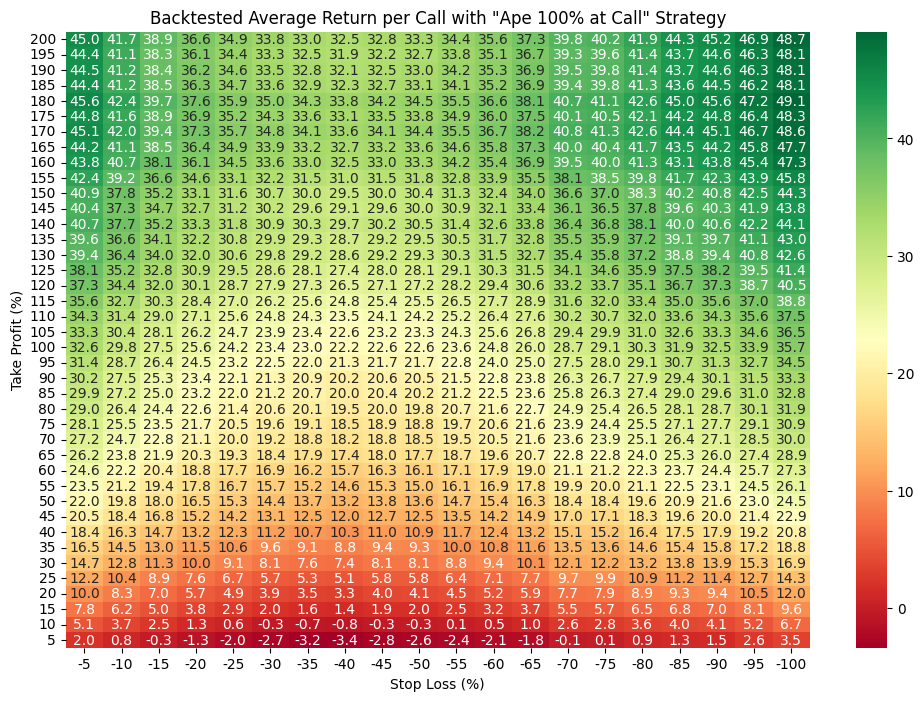

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define TP and SL ranges (as percentages)
tp_levels = np.arange(5, 205, 5)  # Example: 5% to 100% in 5% increments
sl_levels = np.arange(-5, -105, -5)  # Example: -5% to -100% in 5% increments

# Initialize a matrix to store the average return for each TP and SL combination
average_returns = np.zeros((len(tp_levels), len(sl_levels)))

# Step 2: Backtest for each TP and SL combination
for i, tp in enumerate(tp_levels):
    for j, sl in enumerate(sl_levels):
        total_return = 0
        count = 0
        for result in results:
            max_gain = result['max_gain_percent']
            max_loss = result['max_loss_percent']

            if max_gain >= tp:
                total_return += tp  # Assume taking profit at TP level
            elif max_loss <= sl:
                total_return += sl  # Assume stopping loss at SL level
            # No action if the call doesn't hit TP or SL levels
            count += 1

        if count > 0:
            average_returns[i, j] = total_return / count
        else:
            average_returns[i, j] = 0

# Step 3: Create the flipped heatmap
plt.figure(figsize=(12, 8))
# Flip the average_returns matrix vertically
flipped_average_returns = np.flipud(average_returns)
# Use reversed tp_levels for yticklabels
sns.heatmap(flipped_average_returns, cmap='RdYlGn', annot=True, fmt=".1f",
            xticklabels=sl_levels, yticklabels=tp_levels[::-1])
plt.title('Backtested Average Return per Call with "Ape 100% at Call" Strategy')
plt.xlabel('Stop Loss (%)')
plt.ylabel('Take Profit (%)')
plt.show()
average_returns_tpsl = average_returns

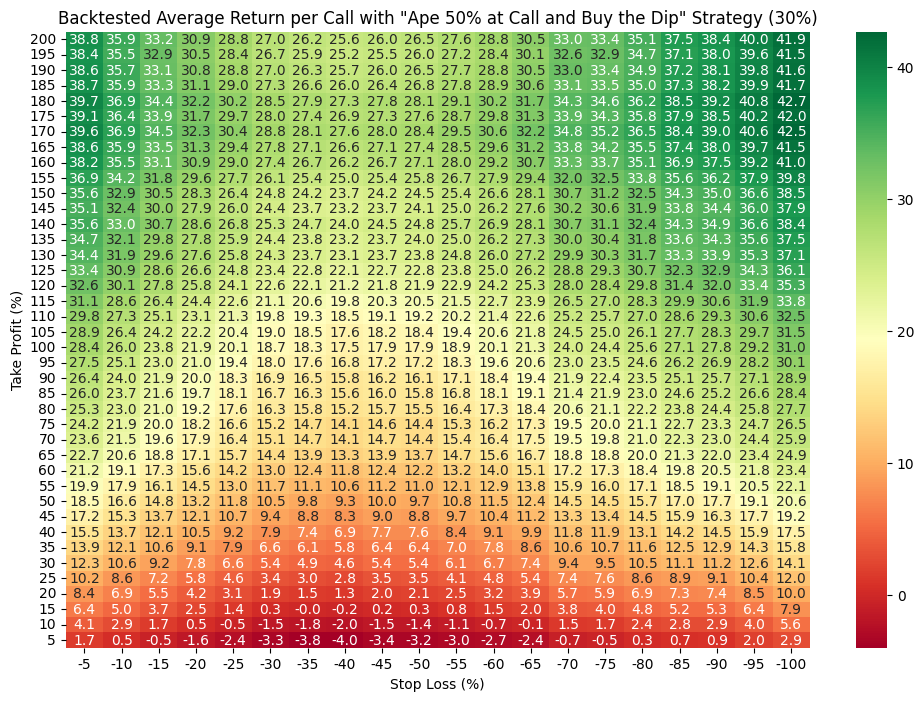

In [98]:
# Define TP and SL ranges
tp_levels = np.arange(5, 205, 5)
sl_levels = np.arange(-5, -105, -5)

# Purchase 2 dip percentage
dip_percentage = -30  # 10% dip below the call price for the second purchase

# Initialize a matrix for average returns
average_returns = np.zeros((len(tp_levels), len(sl_levels)))

# Backtest for each TP and SL combination
for i, tp in enumerate(tp_levels):
    for j, sl in enumerate(sl_levels):
        total_return = 0
        count = 0
        for result in results:
            max_gain = result['max_gain_percent']
            max_loss = result['max_loss_percent']

            p1_return = 0
            p2_return = 0

            # Purchase 1 is made at the call price
            if max_gain >= tp:
                p1_return = tp / 2  # Profit from P1
            elif max_loss <= sl:
                p1_return = sl / 2  # Loss from P1

            # Check if Purchase 2 conditions are met (dip below 10%)
            if max_loss <= dip_percentage:
                if max_gain >= tp:
                    p2_return = tp / 2  # Profit from P2
                elif max_loss <= sl:
                    p2_return = sl / 2  # Loss from P2

            total_return += (p1_return + p2_return)
            count += 1

        if count > 0:
            average_returns[i, j] = total_return / count
        else:
            average_returns[i, j] = 0

# Create the flipped heatmap
plt.figure(figsize=(12, 8))
flipped_average_returns = np.flipud(average_returns)
sns.heatmap(flipped_average_returns, cmap='RdYlGn', annot=True, fmt=".1f", xticklabels=sl_levels, yticklabels=tp_levels[::-1])
plt.title('Backtested Average Return per Call with "Ape 50% at Call and Buy the Dip" Strategy (30%)')
plt.xlabel('Stop Loss (%)')
plt.ylabel('Take Profit (%)')
plt.show()
average_returns_btd = average_returns

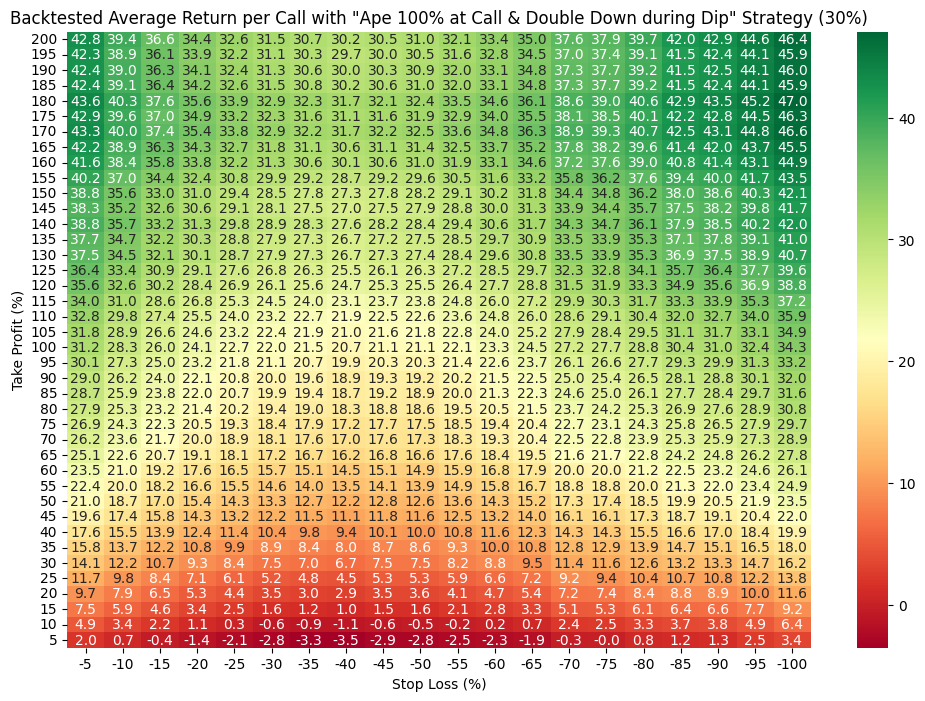

In [102]:
# Define TP and SL ranges
tp_levels = np.arange(5, 205, 5)
sl_levels = np.arange(-5, -105, -5)

# Purchase 2 dip percentage
dip_percentage = -10  # 10% dip below the call price for the second purchase

# Initialize a matrix for average returns for the Double Down strategy
average_returns_dd = np.zeros((len(tp_levels), len(sl_levels)))

# Backtest for each TP and SL combination
for i, tp in enumerate(tp_levels):
    for j, sl in enumerate(sl_levels):
        total_return = 0
        count = 0
        for result in results:
            max_gain = result['max_gain_percent']
            max_loss = result['max_loss_percent']

            p1_return = 0
            p2_return = 0

            # Initial investment is made at the call price
            if max_gain >= tp:
                p1_return = tp  # Profit from initial investment
            elif max_loss <= sl:
                p1_return = sl  # Loss from initial investment

            # Check if conditions for doubling down are met (dip below 10%)
            if max_loss <= dip_percentage:
                if max_gain >= tp:
                    p2_return = tp  # Profit from doubled investment
                elif max_loss <= sl:
                    p2_return = sl  # Loss from doubled investment

            total_return += (p1_return + p2_return)
            count += 1

        if count > 0:
            average_returns_dd[i, j] = total_return*0.5 / count
        else:
            average_returns_dd[i, j] = 0

# Create the heatmap for the Double Down strategy
plt.figure(figsize=(12, 8))
flipped_average_returns_dd = np.flipud(average_returns_dd)
sns.heatmap(flipped_average_returns_dd, cmap='RdYlGn', annot=True, fmt=".1f", xticklabels=sl_levels, yticklabels=tp_levels[::-1])
plt.title('Backtested Average Return per Call with "Ape 100% at Call & Double Down during Dip" Strategy (30%)')
plt.xlabel('Stop Loss (%)')
plt.ylabel('Take Profit (%)')
plt.show()

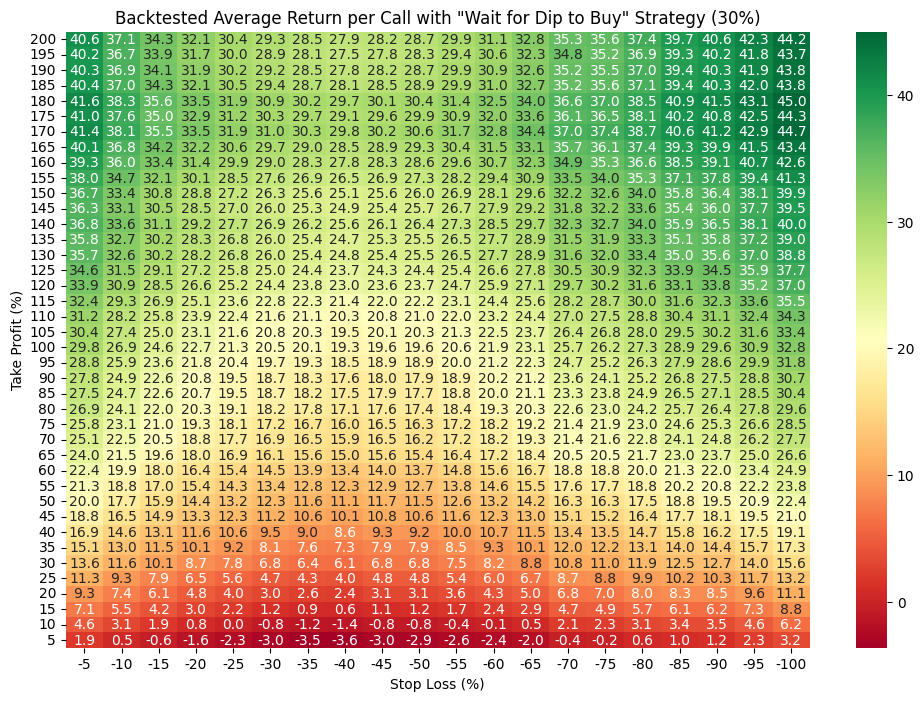

In [119]:
# Define TP and SL ranges
tp_levels = np.arange(5, 205, 5)
sl_levels = np.arange(-5, -105, -5)

# Purchase 2 dip percentage
dip_percentage = -10  # 10% dip below the call price for the purchase

# Initialize a matrix for average returns for the Wait for Dip strategy
average_returns_wfd = np.zeros((len(tp_levels), len(sl_levels)))

# Backtest for each TP and SL combination
for i, tp in enumerate(tp_levels):
    for j, sl in enumerate(sl_levels):
        total_return = 0
        count = 0
        for result in results:
            max_gain = result['max_gain_percent']
            max_loss = result['max_loss_percent']

            p2_return = 0

            # Check if the dip condition is met
            if max_loss <= dip_percentage:
                # Only make a purchase if the dip occurs
                if max_gain >= tp:
                    p2_return = tp  # Profit from the purchase at the dip
                elif max_loss <= sl:
                    p2_return = sl  # Loss from the purchase at the dip

            total_return += p2_return
            count += 1

        if count > 0:
            average_returns_wfd[i, j] = total_return / count
        else:
            average_returns_wfd[i, j] = 0

# Create the heatmap for the Wait for Dip strategy
plt.figure(figsize=(12, 8))
flipped_average_returns_wfd = np.flipud(average_returns_wfd)
sns.heatmap(flipped_average_returns_wfd, cmap='RdYlGn', annot=True, fmt=".1f", xticklabels=sl_levels, yticklabels=tp_levels[::-1])
plt.title('Backtested Average Return per Call with "Wait for Dip to Buy" Strategy (30%)')
plt.xlabel('Stop Loss (%)')
plt.ylabel('Take Profit (%)')
plt.show()

In [115]:
total_time_to_loss = 0
total_time_to_gain = 0

# Iterate through each result to calculate time differences
for result in results:
    bot_call = np.datetime64(result['time_of_bot_call'])
    max_loss = np.datetime64(result['time_of_max_loss'])
    max_gain = np.datetime64(result['time_of_max_gain'])
    
    # Calculate time differences in minutes
    time_to_loss = (max_loss - bot_call) / np.timedelta64(1, 'm')
    time_to_gain = (max_gain - bot_call) / np.timedelta64(1, 'm')
    
    total_time_to_loss += time_to_loss
    total_time_to_gain += time_to_gain

# Calculate average times
average_time_to_loss = total_time_to_loss / len(results)
average_time_to_gain = total_time_to_gain / len(results)

average_time_to_loss, average_time_to_gain

(395.5292207792208, 1438.1623376623377)

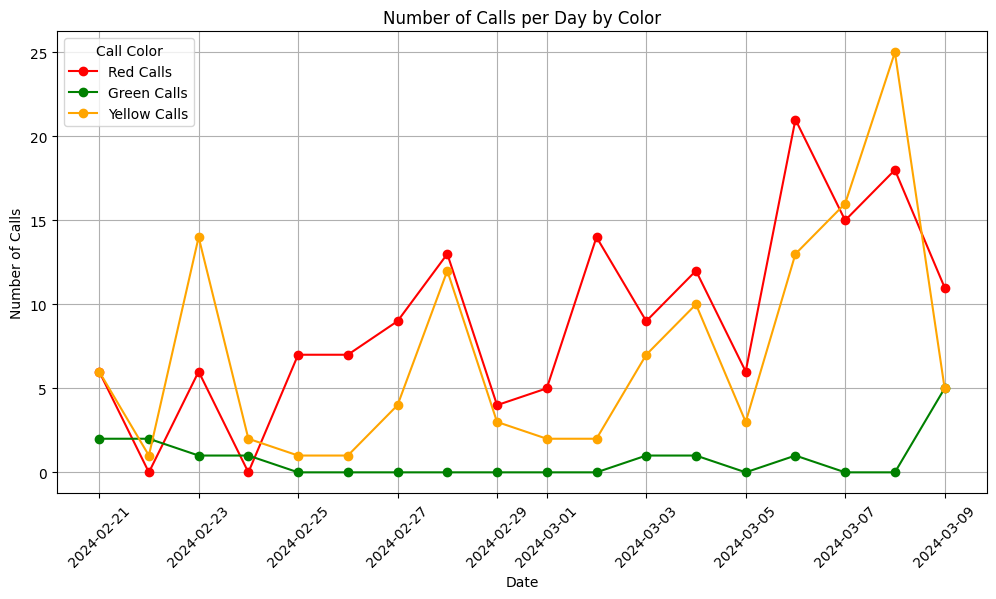

In [118]:
data = results
# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Convert the 'time_of_bot_call' column to datetime
df['time_of_bot_call'] = pd.to_datetime(df['time_of_bot_call'])

# Extract just the date from 'time_of_bot_call'
df['date'] = df['time_of_bot_call'].dt.date

# Filter out "unknown" colors
df_filtered = df[df['color'] != 'unknown']

# Group by date and color, then count the number of calls for each group
grouped = df_filtered.groupby(['date', 'color']).size().unstack(fill_value=0)

# Plot each color line separately to allow for manual color editing
plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped['red'], marker='o', color='red', label='Red Calls')
plt.plot(grouped.index, grouped['green'], marker='o', color='green', label='Green Calls')
plt.plot(grouped.index, grouped['yellow'], marker='o', color='orange', label='Yellow Calls')

plt.title('Number of Calls per Day by Color')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.grid(True)
plt.legend(title='Call Color')
plt.show()